# Running RAVEN on a multi-basin NetCDF file in parallel

Here we use birdy's WPS client to launch the GR4JCN hydrological model on the server for 2 basins in parallel. The NetCDF is thus a 2d file. We then analyze the outputs. 

In [1]:
#Import necessary packages and start the service 
from birdy import WPSClient

from example_data import TESTDATA
import datetime as dt
from urllib.request import urlretrieve
import xarray as xr
import numpy as np
from matplotlib import pyplot as plt
import os

# Set environment variable WPS_URL to "http://localhost:9099" to run on the default local server
url = os.environ.get("WPS_URL", "https://pavics.ouranos.ca/twitcher/ows/proxy/raven/wps")
wps = WPSClient(url)

In [2]:
# The model parameters for gr4jcn for both catchments. Can either be a string of comma separated values, a list, an array or a named tuple. 
gr4jcn1 ='0.529, -3.396, 407.29, 1.072, 16.9, 0.947'
gr4jcn2 ='0.28, -3.6, 380.9, 1.092, 14.6, 0.831'

params=[gr4jcn1,gr4jcn2]

# Forcing files. Raven uses the same forcing files for all and extracts the information it requires for each model.
ts=TESTDATA['input2d']

# Model configuration parameters.
config = dict(
    start_date=[dt.datetime(2000, 1, 1),dt.datetime(2000, 1, 1)],
    end_date=[dt.datetime(2002, 1, 1),dt.datetime(2002, 1, 1)],
    area=[4250.6,5000],
    elevation=[843.0,780],
    latitude=[54.4848,48.0],
    longitude=[-123.3659,-122.99],
    nc_index=[0,0],
    )

# Launch the WPS to get the multi-model results.  Note the "gr4jcn" and "hmets" keys.
resp=wps.raven_gr4j_cemaneige(ts=str(ts),params=params, **config) 

# And get the response
# With `asobj` set to False, only the reference to the output is returned in the response. 
# Setting `asobj` to True will retrieve the actual files and copy the locally.
[hydrograph, storage, solution, diagnostics, rv] = resp.get(asobj=True)

In [3]:
# Print the diagnostics for both catchments
print(diagnostics)

['observed data series,filename,DIAG_NASH_SUTCLIFFE,DIAG_RMSE,\nHYDROGRAPH,/tmp/pywps_process_9svj3n76/input2d.nc,-0.117301,37.9493,\n', 'observed data series,filename,DIAG_NASH_SUTCLIFFE,DIAG_RMSE,\nHYDROGRAPH,/tmp/pywps_process_9svj3n76/input2d.nc,0.21155,31.879,\n']


The `hydrograph` and `storage` outputs are netCDF files storing the time series. These files are opened by default using `xarray`, which provides convenient and powerful time series analysis and plotting tools. 

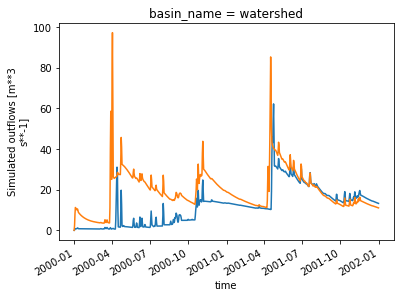

In [4]:
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

# Plot the hydrographs for both basins
hydrograph.q_sim.isel(nbasins=0).plot.line(hue='realization')
hydrograph.q_sim.isel(nbasins=1).plot.line(hue='realization')

The individual configuration files for each model run can be accessed as a Zip archive. 

In [5]:
[hydrograph, storage, solution, diagnostics, rv] = resp.get(asobj=False)
print ("RV configuration", rv)

RV configuration https://pavics.ouranos.ca/wpsoutputs/51fad3f0-098f-11eb-b49c-b052162515fb/rv.zip
